<a href="https://www.kaggle.com/code/hsw1212/mnist-digitrecognizer-convnet?scriptVersionId=139282566" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


In [3]:
train_data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_data = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

y = train_data['label'].to_numpy()
x_train = train_data.drop('label',axis = 1).to_numpy()
x_test = test_data.to_numpy()

In [4]:
x_train = train_data.drop('label',axis = 1).to_numpy()
x_test = test_data.to_numpy()

# Reshape 1D array to 2D image.
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

# Device configuration
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 30
batch_size = 64
learning_rate = 0.001

True


In [5]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y, test_size=0.2, random_state=42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
# define dataset
class MNISTdataset(Dataset):
    def __init__(self, imgs, labels, transform=None):
        self.imgs = imgs
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        sample = self.imgs[index]
        label = self.labels[index]

        if self.transform:
            sample = self.transform(sample)
            
        sample = sample.float()
        return sample, label

transform = transforms.Compose([transforms.ToTensor()])
train_dataset =MNISTdataset(x_train, y_train, transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
val_dataset =MNISTdataset(x_val, y_val, transform)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# model build
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 7 * 7, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [8]:
model = VGG16().to(device)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(weights_init)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_accuracy = correct / total
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {val_accuracy:.4f}')

print('Training Finished!')

Epoch [1/30], Validation Accuracy: 0.9807
Epoch [2/30], Validation Accuracy: 0.9829
Epoch [3/30], Validation Accuracy: 0.9818
Epoch [4/30], Validation Accuracy: 0.9874
Epoch [5/30], Validation Accuracy: 0.9899
Epoch [6/30], Validation Accuracy: 0.9863
Epoch [7/30], Validation Accuracy: 0.9906
Epoch [8/30], Validation Accuracy: 0.9888
Epoch [9/30], Validation Accuracy: 0.9882
Epoch [10/30], Validation Accuracy: 0.9867
Epoch [11/30], Validation Accuracy: 0.9876
Epoch [12/30], Validation Accuracy: 0.9901
Epoch [13/30], Validation Accuracy: 0.9895
Epoch [14/30], Validation Accuracy: 0.9906
Epoch [15/30], Validation Accuracy: 0.9904
Epoch [16/30], Validation Accuracy: 0.9908
Epoch [17/30], Validation Accuracy: 0.9880
Epoch [18/30], Validation Accuracy: 0.9850
Epoch [19/30], Validation Accuracy: 0.9905
Epoch [20/30], Validation Accuracy: 0.9879
Epoch [21/30], Validation Accuracy: 0.9900
Epoch [22/30], Validation Accuracy: 0.9927
Epoch [23/30], Validation Accuracy: 0.9904
Epoch [24/30], Valid

In [9]:
class TESTdataset(Dataset):
    def __init__(self, imgs, transform=None):
        self.imgs = imgs
        self.transform = transform
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        sample = self.imgs[index]

        if self.transform:
            sample = self.transform(sample)
        
        sample = sample.float()
        return sample

test_dataset =TESTdataset(x_test, transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [10]:
pred = []

for batch_inputs in test_loader:
    batch_inputs = batch_inputs.to(device)
    batch_outputs = model(batch_inputs) 
    _, predicted = torch.max(batch_outputs, 1) 
    pred.extend(predicted.cpu().numpy())

In [11]:
import numpy as np
output = pd.DataFrame({'ImageId': np.arange(1,len(pred)+1), 'Label': pred})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


Text(0.5, 1.0, '5')

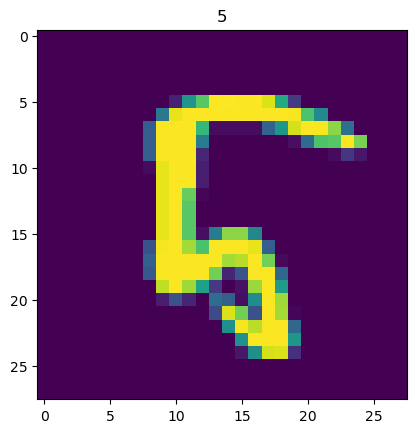

In [12]:
import matplotlib.pyplot as plot

idx=10002

plot.figure(0)
plot.imshow(x_test[idx,:,:,0])
plot.title(str(pred[idx]))